# Intro To JAX

In this workshop we will walk through a crash course in JAX, going through everthing you need to know to start developing algorithms on Google Cloud TPU's🌩️! 

### &#x1F440; **Contents**

* &#x1F6A7; [Setup](#scrollTo=uTgyaSXdXTV2&line=1&uniqifier=1)

* 🤔 [What Is JAX](#scrollTo=JGkHAequ08zr&line=1&uniqifier=1)

* 😀 [JAX Basics](#scrollTo=Q8dT4n8DebuP&line=1&uniqifier=1)

    * 🏍️ [Accelerated Numpy](#scrollTo=4ZM6E8Zl01Wf&line=1&uniqifier=1)

    * 🔒 [Immutability](#scrollTo=WM2fgptY1tYg&line=1&uniqifier=1)

    * 🎲 [Randomness](#scrollTo=VEwV_x1iAJ7_&line=1&uniqifier=1)

    * 🖥️ [Agnostic Backend](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

* 🤖 [JAX Transformations](#scrollTo=6qPm35e3eh2U&line=1&uniqifier=1)

    * [Jit](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Grad](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Vmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Pmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

* 📈 [Model Training](#)

* 🔢[Coding Challenge](#)

* 📚 [Further Reading?](#)


# Setup 

In [88]:
## Install and import anything required. Capture hides the output from the cell.

import subprocess
import os

# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output('nvidia-smi')
    print("a GPU is connected.")
except Exception: 
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
      print("A TPU is connected.")
      import jax.tools.colab_tpu
      jax.tools.colab_tpu.setup_tpu()
    else:
      print("Only CPU accelerator is connected.")
      # x8 cpu devices - number of (emulated) host devices
      os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

Only CPU accelerator is connected.


In [ ]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [ ]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# 🤔 What is JAX? 

JAX is a **high performance**, numerical computing library which focuses on generating **optimized code**, as **simply** as possible.

By combining the best of NumPy, Autograd, and XLA (Accelerated Linear Algebra), JAX enables users to express complex algorithms while maintaining high performance. 

JAX focuses on providing minimal, yet powerful, low level operations and transformations that empower user to easily develop and scale scientific based experiments. 

To top it off, JAX automatically scales to all major Hardware Accelerators without the need for any code changes.


# JAX Basics


## Pure Functions

JAX provides powerful transformations to help accelerate your code, but in order to do this relaibaly, JAX has be designed to with **pure functions**. These functions have the following properties:

1. All **input** data is passed through the **function's parameters**. 
2. All **results** are output through the **function's return**. 
3. The function always returns the same **result** if invoked with the **same inputs**. What if your function involves randomness? Pass in the random seed!
4. **No [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science))** - no mutation of non-local variables or input/output streams.  


In [ ]:
# Impure - Bad

global_term = 3
outputs = 0

def impure_function(x: int) -> None:
    outputs = x + global_term 

# Pure - Good

def pure_function(x: int, term: int) -> int:
    return x + term

## Accelerated Numpy 

JAX is frequently refered to as **Accelerated Numpy**.
The main similarity between JAX and NumPy is that they share a similar interface and often, JAX and NumPy arrays can be used interchangeably. Most methods in NumPy will have a jax counter part, making JAX easier to pick up if you are already familiar with Numpy.

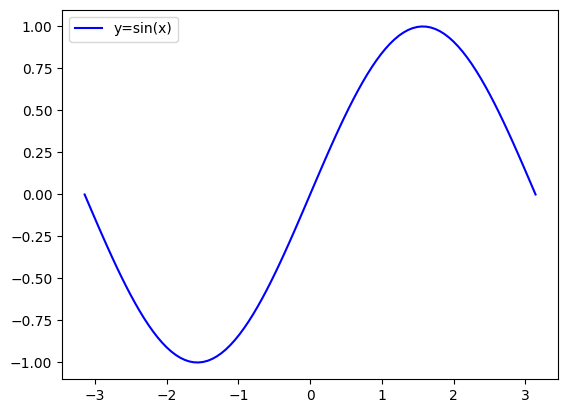

In [ ]:
# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

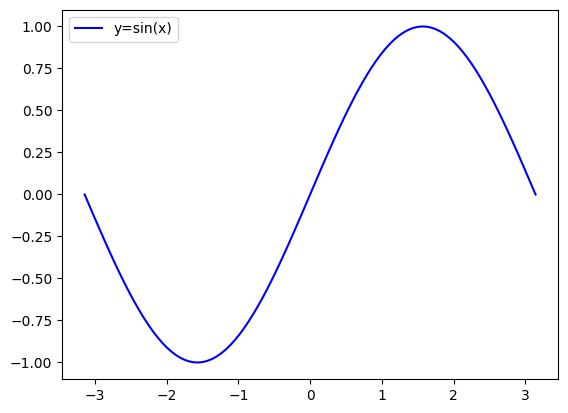

In [ ]:
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

## Immutability

One of the key differences between Numpy and JAX is that Jax arrays are **immutable** (they can't be modified after they are created). Allowing mutations makes transforms difficult and violates conditions for [pure functions](https://en.wikipedia.org/wiki/Pure_function).

In [ ]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [ ]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

Exception '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [ ]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

 new_x: [10  1  2  3  4  5  6  7  8  9] original x: [0 1 2 3 4 5 6 7 8 9]


## Randomness
Pseudo Random Number Generation (PRNG) is the process of algorithmically generating a sequence of numbers, which approximate the properties of a sequence of random numbers. JAX is more explicit in PRNG than NumPy and other libraries (such as TensorFlow or PyTorch) and uses a modern PRNG algorithm([Threefry counter-based PRNG](https://bashtage.github.io/randomgen/bit_generators/threefry.html)) that handles the random state explicitly.

Let's see the differences in how JAX and NumPy generate random numbers.

In [ ]:
# Set random seed
np.random.seed(42)
prng_state = np.random.get_state()

In [ ]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

In [ ]:
# Example of PRNG in numpy, generate independent samples each time

print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

sample 1 = 0.4967141530112327 Did prng state change: True
sample 2 = -0.13826430117118466 Did prng state change: True
sample 3 = 0.6476885381006925 Did prng state change: True


In [ ]:
# Example of PRNG in JAX, same key will always provide the same output
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

sample 1 = -0.1847117692232132
sample 2 = -0.1847117692232132
sample 3 = -0.1847117692232132


In [ ]:
# Example of splitting our random key in order to generate independent 
# samples with JAX

from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

sample 1 = -0.1847117692232132
sample 2 = 1.369469404220581
sample 3 = -0.19947023689746857


##Agnostic Backend



In [ ]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

82.5 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()

38.2 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


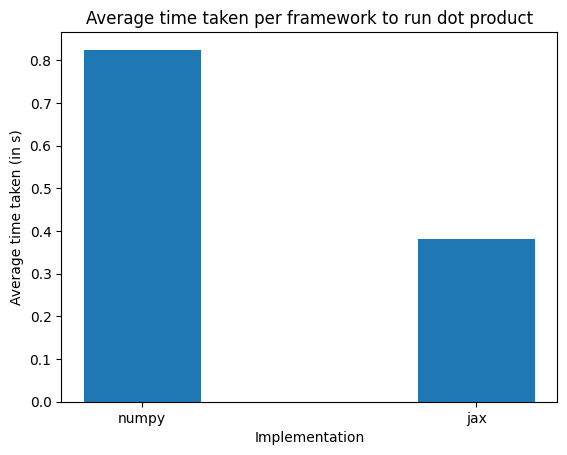

jax was 2.16 times faster than numpy !!!


In [ ]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

# JAX Transformations

JAX transformations are functions that help modify and manipulate your normal python functions to execute them efficiently on hardware accelerators like TPUs.

##Jit Compiling

JIT compilers compile the code during execution, translating parts of the source code into machine code just before they are run. 

This allows for optimizations tailored to the specific runtime context, such as function inlining, loop unrolling, or type specialization, and can lead to significant performance improvements.

In [ ]:
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)

The slowest run took 11.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1.83 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
431 µs ± 26.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


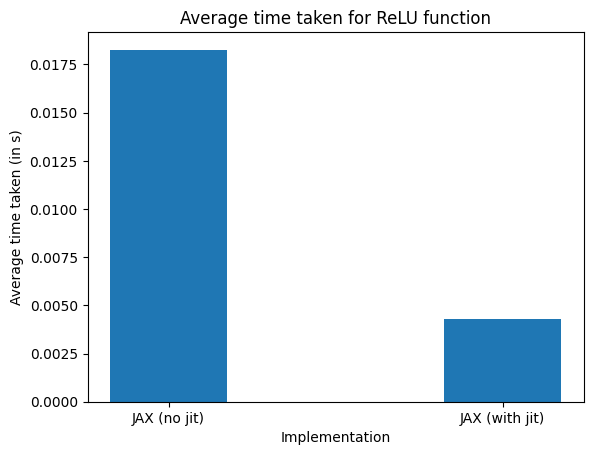

JAX (with jit) was 4.24 times faster than JAX (no jit) !!!


In [ ]:
# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

##Grad

Grad allows us to easily calculate the gradients of a given function. 

In [ ]:
f = lambda x: 6 * x**4 - 9 * x + 4

In [ ]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

print("Grad of f(3): ", dfdx_3)

Grad of f(3):  639.0


In [ ]:
d3dx = grad(grad(grad(f)))
print("3rd order gradients of f(3): ", d3dx(3.0))

3rd order gradients of f(3):  432.0


##Vmap

 Vmap vectorizes or "maps" a function over some dimension of its input. Essentially, it transforms a function that works on single data points into a function that works on batches of data points, allowing for efficient parallel computation.

In [ ]:
# @title Illustration of Manual Batching (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_vectorized-1.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [ ]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

In [ ]:
x = jnp.arange(5)
min_max(x)

Array([0, 4], dtype=int32)

In [ ]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


In [ ]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


In [ ]:
# @title Illustration of Vectorized Batching (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/vectorized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [ ]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

Single vector: [[0 4]]
Batch/list of vector:[[ 0  4]
 [ 5  9]
 [10 14]]


In [ ]:
batched_x = np.arange(5000).reshape((50, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

53.2 µs ± 5.98 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 8.07 times longer than the fastest. This could mean that an intermediate result is being cached.
30.7 µs ± 37 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Avg Times (lower is better) - Naive Implementation: 0.00053 Vmapped Function: 0.00031 


##Pmap

In [ ]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [ ]:
# Let's generate a batch of size 8, each with a matrix of size (500, 600)

# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

266 ms ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
# @title Illustration of Parallel Dot Product (Run me)
HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/parallelized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [ ]:
# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

In [ ]:
print(mats.shape)

(8, 500, 600)


In [ ]:
print(type(mats))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [ ]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

66 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


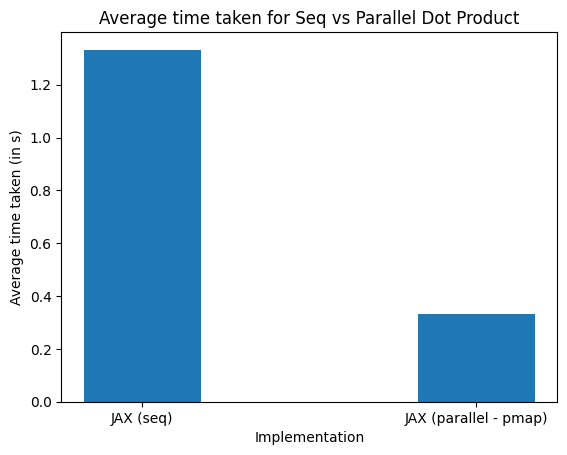

JAX (parallel - pmap) was 4.04 times faster than JAX (seq) !!!


In [ ]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

# 👷 Building JAX Models


In [89]:
%%capture
# @title Install Haiku and Optax. (Run Cell)
!pip install -U dm-haiku
!pip install -U optax
# For plotting.
!pip install livelossplot

In [98]:
# @title JAX Data Parallel Linear Regression with Haiku and Optax
from typing import NamedTuple
import haiku as hk
import jax
from jax import numpy as jnp
import tensorflow as tf
import numpy as np
import optax
import functools

class TrainingState(NamedTuple):
    """Container for the training state."""
    params: hk.Params
    opt_state: optax.OptState
    step: jnp.DeviceArray

def model_fn(x):
  net = hk.Sequential([
    hk.Linear(output_size=1, name='linear')
  ])
  return net(x)

# Transforms the model function into a pair of pure functions using Haiku's init and apply functions.
model = hk.without_apply_rng(hk.transform(model_fn))

def loss_fn(params, xs, ys):
  """Computes the least squares error of the model's predictions on x against y."""
  pred = model.apply(params, xs)
  return jnp.mean((pred - ys) ** 2)

@functools.partial(jax.pmap, axis_name='num_devices')
def update(state, xs, ys):
  """Performs one SGD update step on params using the given data."""

  loss, grads = jax.value_and_grad(loss_fn)(state.params, xs, ys)

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # Also combine the loss. Unnecessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Use optax to update the gradients.
  updates, new_opt_state = optimizer.update(grads, state.opt_state)
  new_params = optax.apply_updates(state.params, updates)

  return TrainingState(new_params, new_opt_state, state.step + 1), loss

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Create a tensorflow dataset
data = tf.data.Dataset.from_tensor_slices((xs, ys))
data = data.batch(128)  # batch size
data = data.repeat()  # batch size


# Convert tf.Dataset to NumPy iterator, for better compatibility with JAX
data_iter = iter(data.as_numpy_iterator())

# Initialise parameters and replicate across devices.
init_params = model.init(jax.random.PRNGKey(123), next(data_iter)[0])
n_devices = jax.local_device_count()
devices = jax.local_devices()

# Initialize the optimizer and its state.
optimizer = optax.sgd(0.005)
opt_state = optimizer.init(init_params)

# Initialize training state
state = TrainingState(init_params, opt_state, jnp.array(0))
state = jax.device_put_sharded([state] * len(devices), devices)

def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Actual training loop.
for i in range(1000):
    # Fetch next batch
    xs, ys = next(data_iter)

    # Reshape xs and ys for the pmapped `update()`.
    x_split = split(xs)
    y_split = split(ys)

    state, loss = update(state, x_split, y_split)

    if i % 100 == 0:
        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss.
        # So, we take the first element to print it.
        print(f"Step {i}, loss: {loss[0]:.3f}")


# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], state.params))

# Printing the trained model's parameters
print("Trained model's parameters:", params)

Step 0, loss: 13.884
Step 100, loss: 2.097
Step 200, loss: 0.544
Step 300, loss: 0.306
Step 400, loss: 0.267
Step 500, loss: 0.260
Step 600, loss: 0.258
Step 700, loss: 0.258
Step 800, loss: 0.258
Step 900, loss: 0.258
Trained model's parameters: {'linear': {'b': array([-1.0037998], dtype=float32), 'w': array([[2.0381863]], dtype=float32)}}


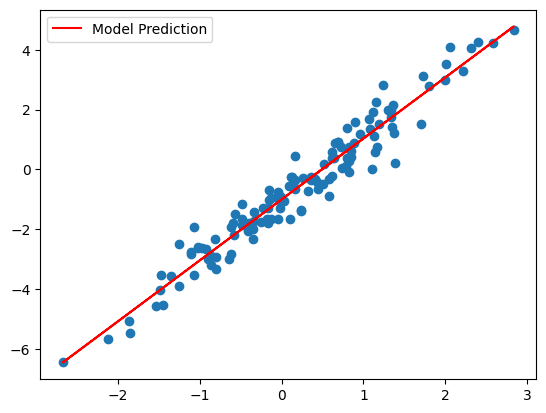

In [99]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params['linear']['w'] * xs + params['linear']['b'], c='red', label='Model Prediction')
plt.legend()
plt.show()

# 🔢 Coding Challenge! 

Now that you have gone through all the key aspects of building a JAX ML model try and test yourself by building out a custom JAX to train on the MNIST dataset. 

If you get stuck, refer back to the Linear Regression example above or check out some of the Further Reading in the section below. 

In [ ]:
import tensorflow_datasets as tfds
import haiku as hk


class Batch(NamedTuple):
    image: np.ndarray  # [B, H, W, 1]
    label: np.ndarray  # [B]

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

# MNIST Dataset
def load_dataset(
    split: str,
    *,
    shuffle: bool,
    batch_size: int,
):
    """Loads the MNIST dataset into a handy TensorFlow Dataset."""
    ds, ds_info = tfds.load("mnist:3.*.*", split=split, with_info=True)
    ds.cache()
    if shuffle:
        ds = ds.shuffle(ds_info.splits[split].num_examples, seed=0)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x: Batch(**x))
    return iter(tfds.as_numpy(ds))


# Model
def net_fn(images: jax.Array) -> jax.Array:
    """Create a simple network that is able to train on the MNIST dataset."""
    # TODO


network = None
optimizer = None
loss_fn = None


@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState, float:
    """Define your learning rule (stochastic gradient descent)."""
    pass


# Make datasets.
train_dataset = load_dataset("train", shuffle=True, batch_size=128)

# Initialise state
state = TrainingState(...)

# Training & evaluation loop.
for step in range(3001):

    # Do SGD on a batch of training examples.
    state, loss = update(state, next(train_dataset))

    if step % 100 == 0:
        print(f"Step {i}, loss: {loss[0]:.3f}")

# 📚Further Reading

This is just a taste of all you can do using JAX. Here are some of our favourite resources for becoming a JAX pro. For a more in depth version of this workshop, make sure to checkout [Intro To ML Using JAX](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Introduction_to_ML_using_JAX.ipynb) from Deep Learning Indaba 2022! 


* [Jax Documentation](https://jax.readthedocs.io/en/latest/)
* [Intro To ML Using JAX](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Introduction_to_ML_using_JAX.ipynb)
* [Awesome Jax: Currated List Of JAX Resources](https://github.com/n2cholas/awesome-jax)
* [JAX Zero To Hero](https://www.youtube.com/watch?v=SstuvS-tVc0&list=PLBoQnSflObckOARbMK9Lt98Id0AKcZurq)
* [Why You Should (Or Shouldn't) Be Using JAX - Assembly AI](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2023/#:~:text=If%20most%20of%20your%20work,to%20use%20JAX%20going%20forward.)